## IMPORTS

In [16]:
import warnings
warnings.filterwarnings("ignore")
import time

from flask import Flask, request, jsonify
from flask_cors import CORS
from PIL import Image
import io, os, subprocess
import base64
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import asyncio
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.color import rgb2gray
from PIL import Image
import tensorflow as tf
from skimage.filters import threshold_otsu
import keras_ocr
from keras.models import load_model
import keras
from tensorflow.keras.layers.experimental.preprocessing import StringLookup # type: ignore

## DOCTR

In [17]:
model_path = 'Res50V2Alpha_without_CTC.h5'
predictor = load_model(model_path)
print("Model", model_path,"Loaded")
AUTOTUNE = tf.data.AUTOTUNE


def check_dir_remove_files(paths):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)
        files = os.listdir(path)
        if len(files) != 0:
            # delete all files in the directory
            for f in files:
                os.remove(os.path.join(path, f))

def inser_img(image, distorted_path, img_name):
    cv2.imwrite(distorted_path + img_name, image)
    print("Copied the image to", distorted_path)
    
def run_inference_doctr(geometric_unwrapping, illumination_rectifying):
    # Define the base directory and script path
    base_dir = os.path.abspath("Backend/DocTr")
    script_path = "inference.py"  # script path relative to base_dir
    
    # Define the command to run the script
    if geometric_unwrapping and not illumination_rectifying:
        command = ["python", script_path]
    elif illumination_rectifying and not geometric_unwrapping:
        command = ["python", script_path, "--ill_rec", "True", "--disable_geo"]
    elif illumination_rectifying and geometric_unwrapping:
        command = ["python", script_path, "--ill_rec", "True"]
    print("Command to send: ", command)
    
    # Run the command from the base_dir
    result = subprocess.run(command, capture_output=True, text=True, cwd=base_dir)
    
    print("Finished Running DocTr Inference")
    
    return result

def check_dir_copy_file(paths):
    for path in paths:
        files = os.listdir(path)
        if len(files) != 0:
            img = cv2.imread(path + files[0])
            cv2.imwrite('Backend/uploaded_image.jpg', img)
            break
    print("Finished Copying File Back")

Model Res50V2Alpha_without_CTC.h5 Loaded


## IMAGE PROCESSING

In [18]:
def denoise(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dst = cv2.fastNlMeansDenoising(image_gray, h=25, templateWindowSize=15, searchWindowSize=35)
    return dst

def resize(img):
    width, height = img.size
    if width > 2000 or height > 2000:
        if width > height:
            ratio = 2000 / width
        else:
            ratio = 2000 / height
        img = img.resize((int(width * ratio), int(height * ratio)), Image.LANCZOS)
    return img

def preproces_image(image, *, kernel_size=15, crop_side=50, blocksize=35, constant=15, max_value=255):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bit = cv2.bitwise_not(gray)
    image_adapted = cv2.adaptiveThreshold(
        src=bit,
        maxValue=max_value,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=blocksize,
        C=constant,
    )
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erosion = cv2.erode(image_adapted, kernel, iterations=2)
    return erosion[crop_side:-crop_side, crop_side:-crop_side]

def find_edges(image_preprocessed, *, bw_threshold=150, limits=(0.2, 0.15)):
    mask = image_preprocessed < bw_threshold
    edges = []
    for axis in (1, 0):
        count = mask.sum(axis=axis)
        limit = limits[axis] * image_preprocessed.shape[axis]
        index_ = np.where(count >= limit)
        _min, _max = index_[0][0], index_[0][-1]
        edges.append((_min, _max))
    return edges

def adapt_edges(edges, *, height, width):
    MAX_EDGE_EXTENSION = 100
    EDGE_EXTENSION_FACTOR = 10
    EDGE_EXTENSION_DIVISOR = 11

    (x_min, x_max), (y_min, y_max) = edges
    x_min2 = x_min
    x_max2 = x_max + min(MAX_EDGE_EXTENSION, (height - x_max) * EDGE_EXTENSION_FACTOR // EDGE_EXTENSION_DIVISOR)
    y_min2 = max(0, y_min)
    y_max2 = y_max + min(MAX_EDGE_EXTENSION, (width - y_max) * EDGE_EXTENSION_FACTOR // EDGE_EXTENSION_DIVISOR)
    return (x_min2, x_max2), (y_min2, y_max2)
#image contrast enhancement
def grayscalize(img):
    #check if its 3 channel or grayscale, based on that convert to grayscale
    if img.ndim > 2: # is this is a rgb/rgba image
        img = rgb2gray(img)
    return img

def binarize_image(image):
    threshold = threshold_otsu(image)
    return image < threshold


def denoise_binary_image(binary_image, kernel_size=5):
    # Define a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    # Perform erosion followed by dilation to remove noise
    denoised_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    return denoised_image

def thresholding(image, threshold, typee='Binary', param1=0, param2=0):
    # A function to apply intensity thresholding to a grey-scale image
    # The thresholding could be simple binary thresholding or adaptive gaussian thresholding
    # If the type is not set to 'Binary' then the parameters for adaptive thresholdinf must
    # be used which are:
    #param1: local region size ( preferably an odd number)
    #param2: constant to be added to local mean
    if(typee.lower()=='binary'):
        ret, thresh= cv2.threshold(image,threshold,255,cv2.THRESH_BINARY_INV)
    else:
        thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,param1,param2)
    return thresh

def edg_enhance(image):
    denoised = denoise_binary_image(image)
    gray = grayscalize(image)
    binarized_image = binarize_image(gray)
    # thresh = thresholding(denoised, 127, typee='Binary')
    #convert image data type to uint8
    binarized_image_uint8 = (binarized_image * 255).astype(np.uint8)
    
    return binarized_image_uint8
def PreProcessTheImage(image):
    try:
        image = Image.fromarray(image)
        # Resize the image
        image = resize(image)
        image = np.array(image)
        height, width = image.shape[0:2]
        # image_preprocessed = preproces_image(image) #skip preprocessing (not needed with CRAFT)
        image_preprocessed = image 
        edges = find_edges(image_preprocessed)
        # (x_min, x_max), (y_min, y_max) = adapt_edges(edges, height=height, width=width)
        # image_cropped = image[x_min:x_max, y_min:y_max]
        print("Finished Preprocessing")
        return image_cropped
    except:
        image_cropped = image
    return image_cropped

In [19]:
image = cv2.imread('test.jpg')

In [20]:
preprocessed_image = PreProcessTheImage(image)

Finished Preprocessing


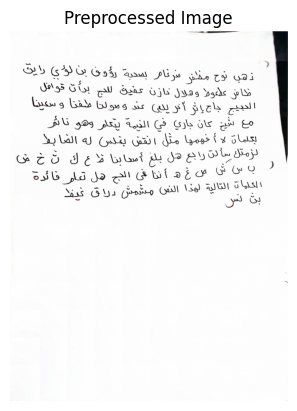

In [21]:
plt.title("Preprocessed Image")
plt.axis('off')
plt.imshow(preprocessed_image)

## DETECT WORDS

In [142]:
def DetectWords(image):
    # padding_size = 100
    # image = np.pad(image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant', constant_values=255) #broken
    words_array = []
    try:
        detector = keras_ocr.detection.Detector(weights='clovaai_general')
        boxes = detector.detect(images=[image], text_threshold=0.3, link_threshold=0.7, size_threshold=10)[0]
        for _, box in enumerate(boxes):
            cropped_img = keras_ocr.tools.warpBox(image=image, box=box, margin=0)
            words_array.append(cropped_img)
        image_with_boxes = keras_ocr.tools.drawBoxes(image=image, boxes=boxes, color=(0, 0, 255), thickness=1, boxes_format='boxes')
    except:
        print('error')
        image_with_boxes = image  # Return the original image if there's an error
    return words_array, image_with_boxes

In [143]:
WordSegments, image_with_boxes = DetectWords(preprocessed_image)

Looking for C:\Users\Ayman\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 1s 520ms/step


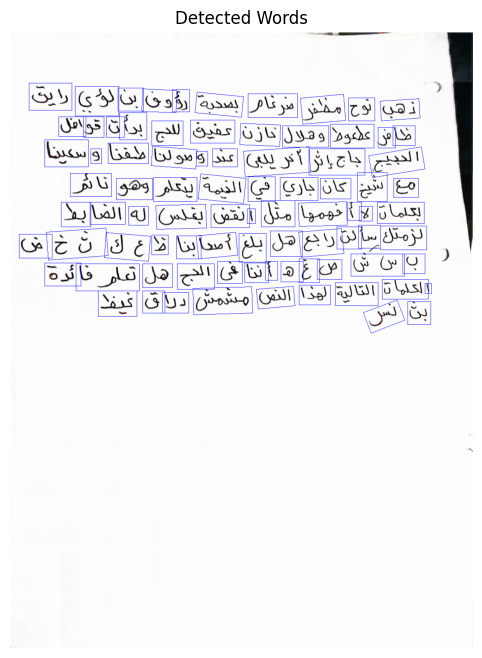

In [144]:
# Create a bigger figure
plt.figure(figsize=(12, 8))  # Adjust the size as needed (width, height)

# Display the image
plt.title('Detected Words')
plt.axis('off')
plt.imshow(image_with_boxes)
plt.show()

In [178]:
def clean_image(image, x_padding=4, y_padding=15):
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Convert to binary image with a lower threshold value
    _, binary = cv2.threshold(image, 240, 255, cv2.THRESH_BINARY_INV)  # Adjust the threshold value as needed
    
    # Optional: Use dilation to make the words thicker
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.dilate(binary, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours are found, return the original image
    if not contours:
        return image
    
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add padding around the bounding box
    x = max(0, x - x_padding)
    y = max(0, y - y_padding)
    w = min(image.shape[1] - x, w + 2 * x_padding)
    h = min(image.shape[0] - y, h + 2 * y_padding)
    
    # Crop the image to the bounding box with padding
    cleaned_image = image[y:y+h, x:x+w]
    
    return cleaned_image

CleanedWordSegments = [clean_image(image) for image in WordSegments]


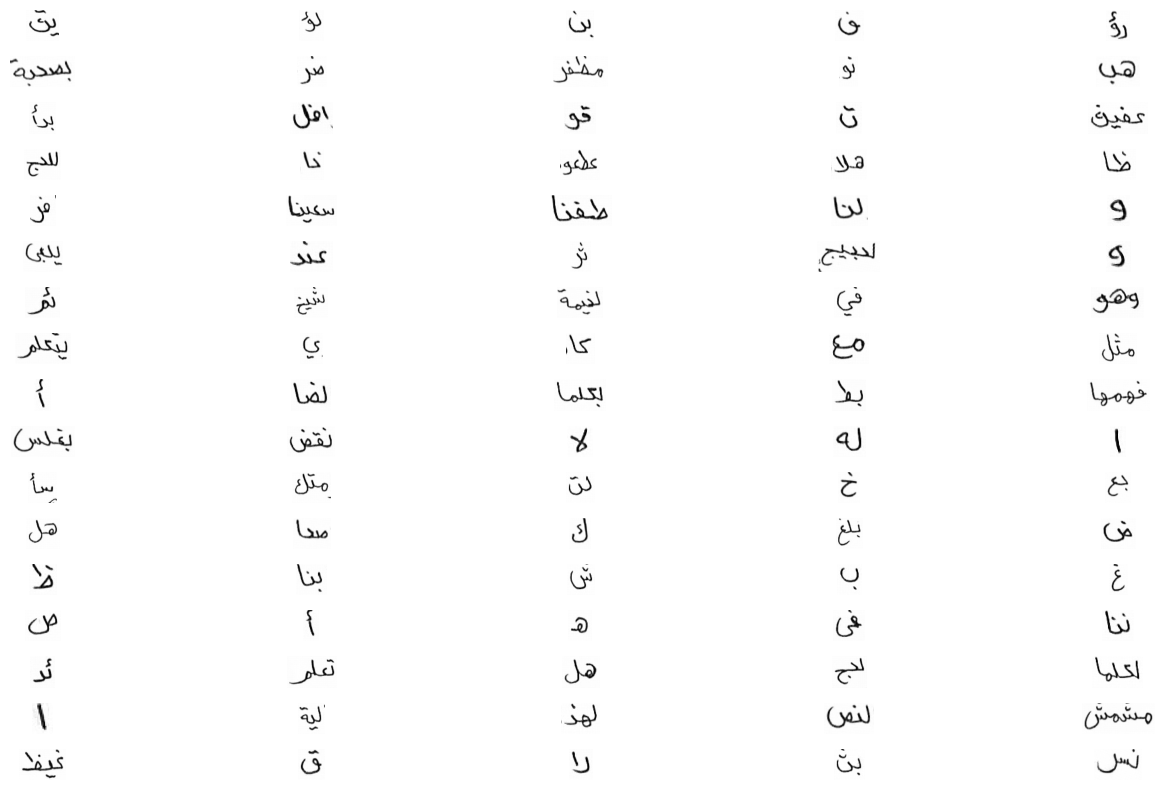

In [179]:
# Determine the number of rows and columns
num_images = len(CleanedWordSegments)
columns = 5  # You can set this to any number of columns you prefer
rows = (num_images + columns - 1) // columns  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(CleanedWordSegments[i], cmap='gray')
        ax.axis('off')  # Hide the axis
    else:
        ax.axis('off')  # Hide the axis for any empty subplot

plt.tight_layout()
plt.show()

In [22]:
def directionalHistogram(img, direction='H'):
    (w,h) = img.shape
    pixel_count = 0
    if(direction=='H'):
        return [img[j].tolist().count(255) for j in range(w-1)]
    else:
        return [img[:,j].tolist().count(255) for j in range(h-1)]

def cropLineToWords(viable_sequences, image):
    (w,h) = image.shape
    words = [image[0:w-1, viable_sequences[i-1]:viable_sequences[i]] for i in range(1,len(viable_sequences))]
    words.append(image[0:w-1, viable_sequences[-1]:h-1])
    return words

def removeSpaces(words):
    return [word for word in words if np.sum(word[:,:]>0)]

def IslandSegmentation(words_array):
    segmented_words = []
    for image in words_array:
        words = []
        (w,h) = image.shape
        hist_vertical = directionalHistogram(image, direction='V')
        zero_sites = np.where(np.asarray(hist_vertical)==0)[0]
        sequences = [[zero_sites[i-1], zero_sites[i]] for i in range(1, len(zero_sites)) if zero_sites[i] != zero_sites[i-1] + 1]
        if not sequences:
            continue
        sequence_lengths = [seq[1] - seq[0] + 1 for seq in sequences]
        average_sequence_length = sum(sequence_lengths[1:-1]) / len(sequences)
        overlap_factor = 0.75 * average_sequence_length
        viable_sequences_unrolled = [seq[0] for seq in sequences if seq[1] - seq[0] + 1 >= average_sequence_length - overlap_factor] + [-1]
        if viable_sequences_unrolled[0] != 0:
            viable_sequences_unrolled = [0] + viable_sequences_unrolled
        words.append(cropLineToWords(viable_sequences_unrolled, image))
        ordered_words = [word if np.sum(word[:,:]) else 'space' for word in words[0]]
        for ordered_word in ordered_words:
            if not isinstance(ordered_word, str):
                segmented_words.append(ordered_word)
    
    return segmented_words
    
def clean_segment(image):
    clean_value = 0.065 #TODO: Tune this value
    # get max value in the image
    max_value = np.max(image)
    # normalize the image to range [0, 1]
    normalized_image = image / max_value
    # get average brightness of the image
    avg = np.average(normalized_image)
    # if the image is too small or too dark, return 'space'
    if image.shape[1] < 10 and avg < 0.05:
        return 'space'
    elif avg <= clean_value:
        return 'space'
    elif avg > clean_value:
        return image
    return image
    
def directionalHistogram(img, direction='H'):
    (w,h) = img.shape
    if(direction=='H'):
        return [img[j].tolist().count(255) for j in range(w-1)]
    else:
        return [img[:,j].tolist().count(255) for j in range(h-1)]

def crop_image(image, direction='H'):
    w,h=image.shape
    if(w<10 or h<10):
        return image
    hist=directionalHistogram(image, direction )
    flipped_hist=np.flip(hist)
    try:
        startpos = next(i for i in range(1, len(hist)-1) if hist[i-1]==0 and hist[i]==0 and hist[i+1]!=0)
        endpos = len(flipped_hist)-1 - next(i for i in range(1, len(flipped_hist)-1) if flipped_hist[i-1]==0 and flipped_hist[i]==0 and flipped_hist[i+1]!=0)
    except StopIteration:
        return image
    cropped_image = image[startpos:endpos,:] if direction == 'H' else image[:,startpos:endpos]
    if cropped_image.shape[0] <= 0 or cropped_image.shape[1] <= 0:
        return image
    return cropped_image

def distortion_free_resize(image, img_size=(64, 64)):
    h,w= img_size
    if h <= 0 or w <= 0:
        raise ValueError("Image size must be positive")
    if image.shape[0] <= 0 or image.shape[1] <= 0:
        return image
    # convert to 3-channel image
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]
    pad_height_top = pad_height // 2 if pad_height % 2 == 0 else pad_height // 2 + 1
    pad_width_left = pad_width // 2 if pad_width % 2 == 0 else pad_width // 2 + 1
    image = tf.pad(image, paddings=[[pad_height_top, pad_height//2], [pad_width_left, pad_width//2], [0, 0]])
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def perform_padding(image):
    image_v_cropped=crop_image(image, 'V')
    image=distortion_free_resize(image_v_cropped)
    image=np.rot90(image)
    return image

In [180]:
# Enhance Edges
WordSegments = [edg_enhance(image) for image in WordSegments]
print("Finished Edge Enhancement")
# Island Segmentation
IslandSegments = IslandSegmentation(WordSegments)
print("Finished Island Segmentation")
# Clean Segments
segmented_words = [clean_segment(image) for image in IslandSegments]
print("Finished Cleaning Segments")
# remove spaces
segmented_words_cleaned = [word for word in segmented_words if not isinstance(word, str)]
print("Finished Removing Spaces")

Finished Edge Enhancement
Finished Island Segmentation
Finished Cleaning Segments
Finished Removing Spaces


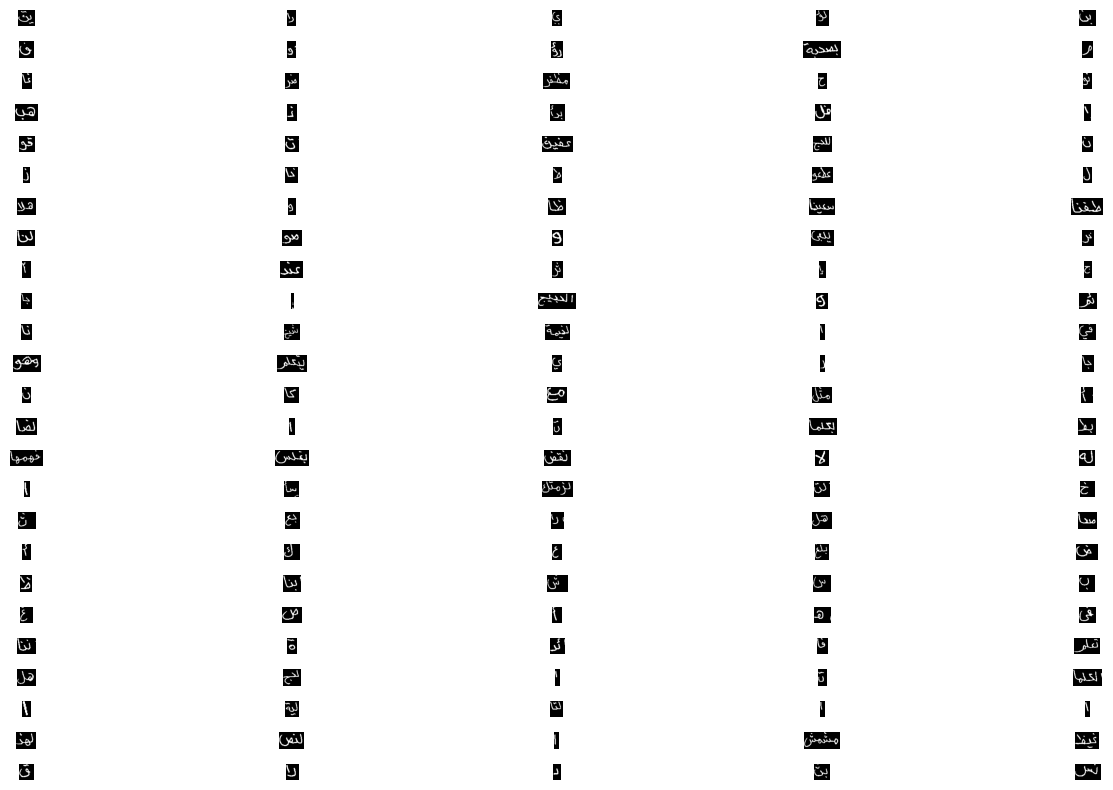

In [181]:
# Determine the number of rows and columns
num_images = len(segmented_words_cleaned)
columns = 5  # You can set this to any number of columns you prefer
rows = (num_images + columns - 1) // columns  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(15, 8))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(segmented_words_cleaned[i], cmap='gray')
        ax.axis('off')  # Hide the axis
    else:
        ax.axis('off')  # Hide the axis for any empty subplot

plt.tight_layout()
plt.show()

## MODEL PREPARATIONS

In [182]:
def PrepareCharacters():
    characters = {'ء','آ','أ','ؤ','إ','ئ','ا','ب','ة','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','م','ن','ه','و','ى','ي'}
    max_len = 7
    # Mapping characters to integers.
    char_to_num = StringLookup(vocabulary=sorted(list(characters)), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return char_to_num, num_to_char, max_len


def decode_batch_predictions(pred, num_to_char, max_len=7):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [183]:
segmented_words = []
for image in segmented_words_cleaned:
    try:
        padded_image = perform_padding(image)
        segmented_words.append(padded_image)
    except Exception as e:
        print(f"Error while padding image: {e}")
print("Finished Padding")
segmented_words = np.array(segmented_words)
# scale images
segmented_words = segmented_words / 255.0
print("Finished Scaling")

Finished Padding
Finished Scaling


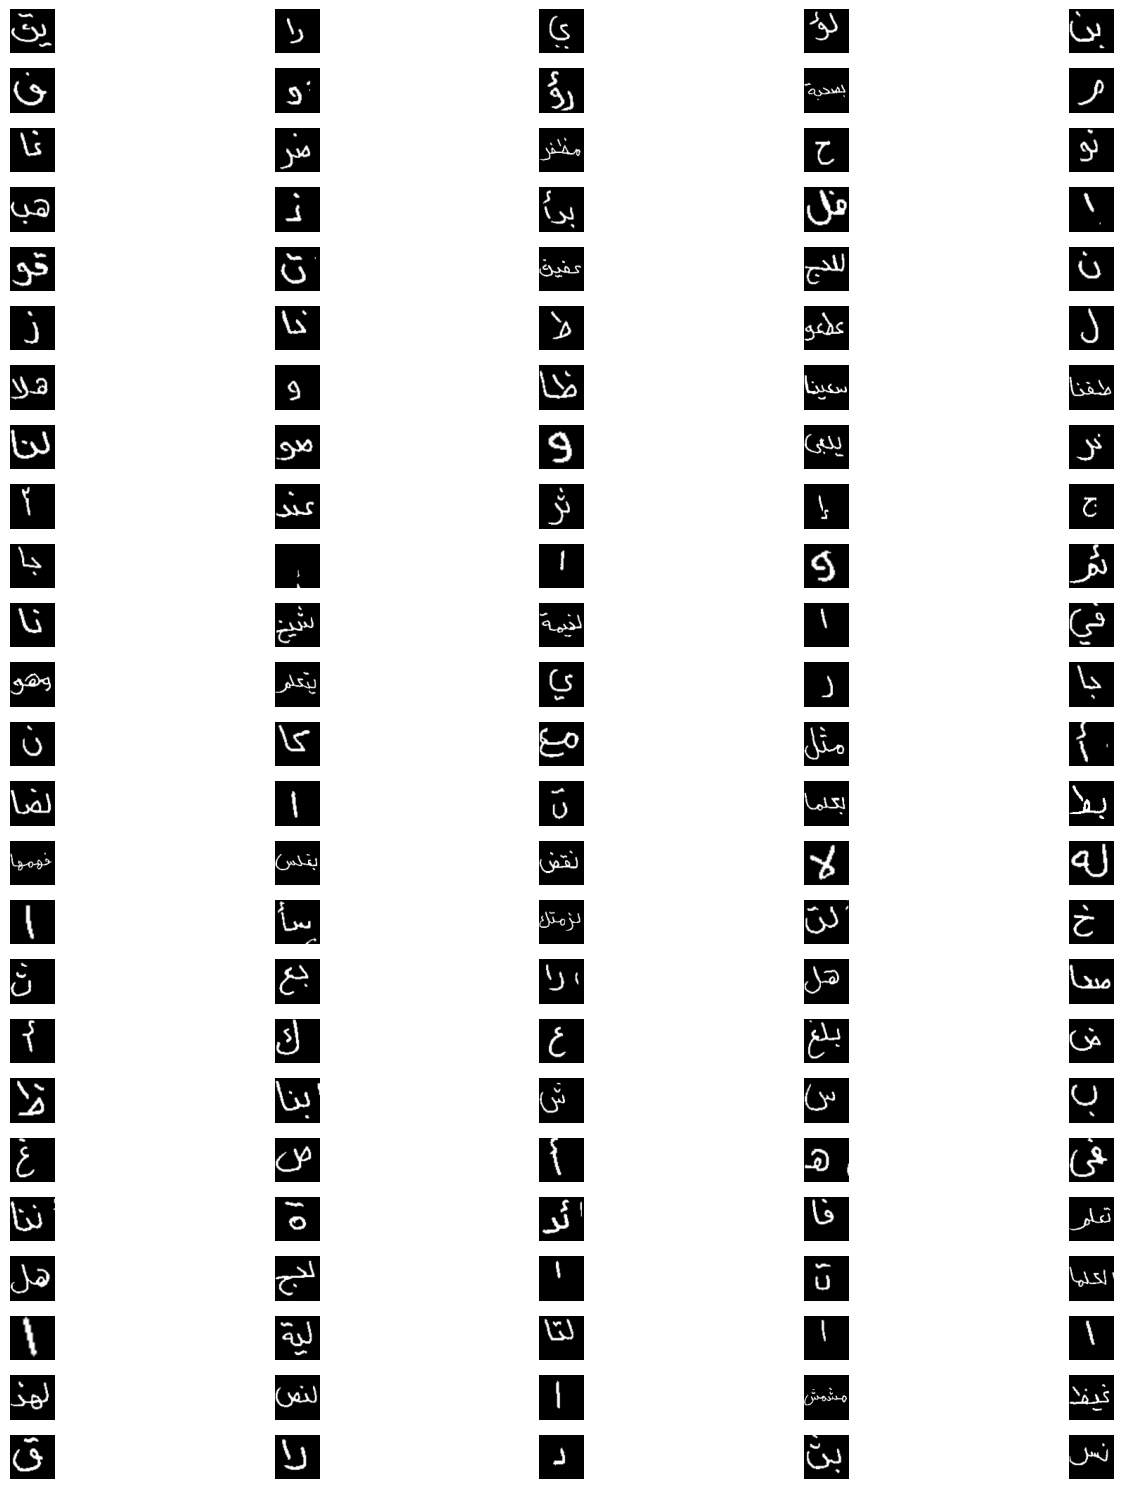

In [185]:
# Determine the number of rows and columns
num_images = len(segmented_words)
columns = 5  # You can set this to any number of columns you prefer
rows = (num_images + columns - 1) // columns  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(segmented_words[i], cmap='gray')
        ax.axis('off')  # Hide the axis
    else:
        ax.axis('off')  # Hide the axis for any empty subplot

plt.tight_layout()
plt.show()

In [186]:
# prepare characters
char_to_num, num_to_char, max_len = PrepareCharacters()
input_array = np.zeros((segmented_words.shape[0],7))
encoded_predictions = predictor.predict([segmented_words, input_array])
print("Finished Predicting")
finalLabels = decode_batch_predictions(encoded_predictions, num_to_char, max_len)
print("Finished Decoding")

# resize images in segmented_words to at least (170x90)
resized_images = []
for img in segmented_words:
    img_pil = Image.fromarray((img * 255).astype(np.uint8))  # convert to uint8
    width, height = img_pil.size
    aspect_ratio = width / height

    if width < 170 or height < 90:
        if width < height:
            new_width = 170
            new_height = round(new_width / aspect_ratio)
        else:
            new_height = 90
            new_width = round(new_height * aspect_ratio)

        img_pil = img_pil.resize((new_width, new_height), Image.LANCZOS)
    resized_images.append(np.array(img_pil) / 255.0)  # convert back to float
print("Finished Resizing for view")
segmented_words = np.array(resized_images)


imgs_arr_base64 = []
for img in segmented_words:
    buffered = io.BytesIO()
    img = Image.fromarray((img * 255).astype(np.uint8))  # convert to uint8
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    imgs_arr_base64.append(img_str)
print("Finished Encoding")

4/4 [==============================] - 2s 36ms/step
Finished Predicting
Finished Decoding
Finished Resizing for view
Finished Encoding


In [192]:
finalLabels = np.array(finalLabels)

In [195]:
finalLabels[0]

'يق'

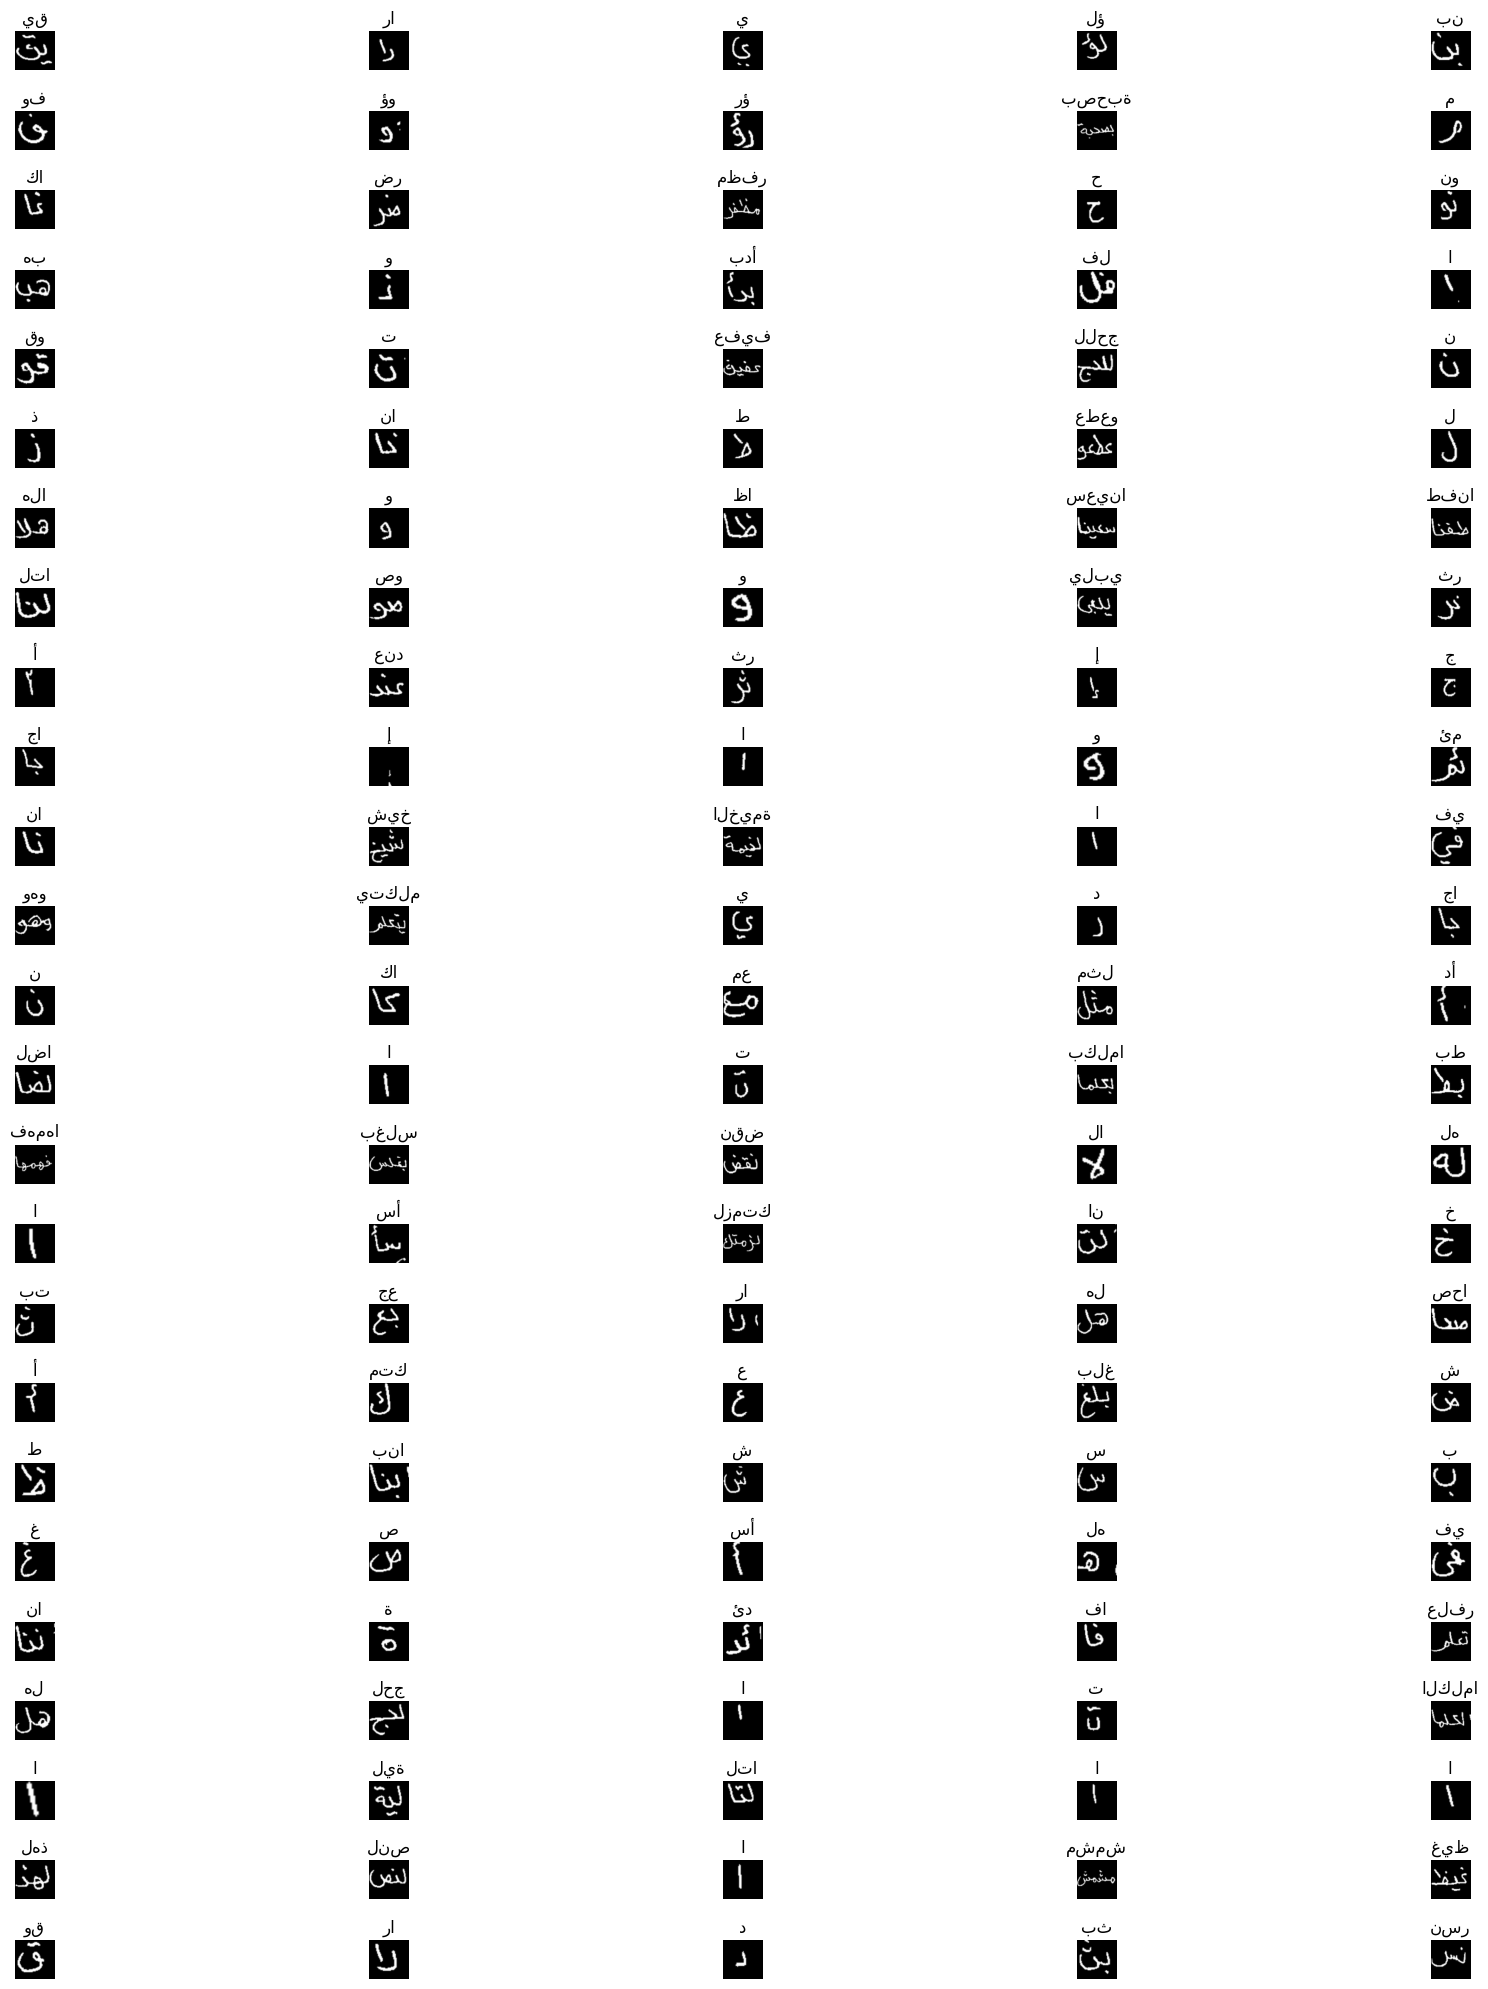

In [200]:
# Determine the number of rows and columns
num_images = len(segmented_words)
columns = 5  # You can set this to any number of columns you prefer
rows = (num_images + columns - 1) // columns  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(segmented_words[i], cmap='gray')
        ax.set_title(f'{finalLabels[i]}')
        ax.axis('off')  # Hide the axis
    else:
        ax.axis('off')  # Hide the axis for any empty subplot

plt.tight_layout()
plt.show()